In [10]:
# @title Data
raw_data = [
    ["Arsenal", 83, 90, 78, 87, 81],
    ["Aston Villa", 47, 56, 45, 50, 60],
    ["Blackburn Rovers", 42, 44, 60, 46, 56],
    ["Bolton Wanderers", 58, 53, 44, 40, 60],
    ["Charlton Athletic", 46, 53, 49, 44, 45],
    ["Chelsea", 95, 79, 67, 64, 71],
    ["Everton", 61, 39, 59, 43, 46],
    ["Fulham", 44, 52, 48, 44, 53],
    ["Liverpool", 58, 60, 64, 80, 54],
    ["Manchester United", 77, 75, 83, 77, 70],
    ["Middlesbrough", 55, 48, 49, 45, 51],
    ["Newcastle United", 44, 56, 69, 71, 64],
    ["Southampton", 32, 47, 52, 45, 55],
    ["Tottenham Hotspur", 52, 45, 50, 50, 59]
]

In [11]:
import numpy as np

def update_mu(Y, sigma_sq, theta, hyperparams):
    '''
    Samples new values for mu_k (Team Means).
    Conditional distribution is normal.
    '''
    K, T = Y.shape
    sigma0 = hyperparams['sigma0']

    # Calculate precisions
    prec_data = 1.0 / sigma_sq        # 1/sigma_k^2
    prec_prior = 1.0 / (sigma0**2)    # 1/sigma_0^2

    # Posterior Precision: T * prec_data + prec_prior
    post_prec = (T * prec_data) + prec_prior
    post_std = np.sqrt(1.0 / post_prec)

    # Posterior Mean
    sum_y = np.sum(Y, axis=1) # Sum over years for each team
    numerator = (prec_data * sum_y) + (theta * prec_prior)
    post_mean = numerator / post_prec

    # Sample new mu vector
    return np.random.normal(loc=post_mean, scale=post_std)

def update_theta(mu, hyperparams):
    '''
    Samples a new value for theta (League Mean).
    Conditional distribution is normal.
    '''
    K = len(mu)
    sigma0 = hyperparams['sigma0']
    mu0 = hyperparams['mu0']
    tau0 = hyperparams['tau0']

    # Calculate precisions
    prec_likelihood = 1.0 / (sigma0**2)
    prec_prior = 1.0 / (tau0**2)

    # Posterior Precision: K * prec_likelihood + prec_prior
    post_prec = (K * prec_likelihood) + prec_prior
    post_std = np.sqrt(1.0 / post_prec)

    # Posterior Mean
    numerator = (prec_likelihood * np.sum(mu)) + (mu0 * prec_prior)
    post_mean = numerator / post_prec

    # Sample new theta
    return np.random.normal(loc=post_mean, scale=post_std)

def update_sigma_sq(Y, mu, hyperparams):
    '''
    Samples new values for sigma_k^2 (Team Variances).
    Conditional distribution is inverse Gamma.
    '''
    K, T = Y.shape
    alpha0 = hyperparams['alpha0']
    beta0 = hyperparams['beta0']

    # Update shape parameter alpha
    alpha_new = alpha0 + (T / 2.0)

    # Update rate parameter beta
    sse = np.sum((Y - mu[:, np.newaxis])**2, axis=1)
    beta_new = beta0 + 0.5 * sse

    # Sample precision from Gamma distribution
    new_precisions = np.random.gamma(shape=alpha_new, scale=1.0/beta_new)

    # Return variance (1 / precision)
    return 1.0 / new_precisions

In [16]:
def initialise_chain(Y):
    '''
    Initializes parameters based on data statistics.
    '''
    init_mu = np.mean(Y, axis=1)
    init_theta = np.mean(init_mu)
    init_sigma_sq = np.var(Y, axis=1, ddof=1)
    init_sigma_sq[init_sigma_sq == 0] = 1.0

    return init_mu, init_theta, init_sigma_sq

def run_gibbs_sampler(Y, hyperparams, n_iter=10000):
    '''
    Runs the MCMC simulation loop.
    '''
    K, T = Y.shape
    curr_mu, curr_theta, curr_sigma_sq = initialise_chain(Y)

    trace_mu = np.zeros((n_iter, K))
    trace_theta = np.zeros(n_iter)
    trace_sigma_sq = np.zeros((n_iter, K))

    for i in range(n_iter):
        curr_mu = update_mu(Y, curr_sigma_sq, curr_theta, hyperparams)
        curr_theta = update_theta(curr_mu, hyperparams)
        curr_sigma_sq = update_sigma_sq(Y, curr_mu, hyperparams)

        trace_mu[i, :] = curr_mu
        trace_theta[i] = curr_theta
        trace_sigma_sq[i, :] = curr_sigma_sq

    return trace_mu, trace_theta, trace_sigma_sq

The prior parameters represent specific assumptions about the distribution of football scores before observing the data:
*   $\mu_0 = 60$: This represents the expected "average" performance of a typical team in the league. Since the maximum possible score is $114$ and the minimum is $0$, our initial prior is the belief that the average team wins roughly half their available points.
*   $\tau_0 = 20$: This is the standard deviation for the parameter $\theta$. It dictates how uncertain we are about the mean of the league. A standard deviation of $20$ implies that the league average $\theta$ is very likely ($95\%$ confidence) to fall between $20$ and $100$. This is a weakly informative prior as it constrains the mean to physically possible scores but allows the data to easily shift the posterior.
*   $\sigma_0 = 10$: This is the standard deviation of individual team means ($\mu_k$) around the league mean ($\theta$). A value of $10$ suggests that most teams' underlying abilities lie within $\pm 20$ points of the league average. This prevents the model from overfitting to a single lucky season by shrinking estimates toward the league average.
*   $\alpha_0 = 10^{-5}, \beta_0 = 10^{-3}$: These are parameters for the inverse-Gamma prior on team variance. These extremely small values constitute an uninformative prior. They have very little influence on the posterior, allowing the observed variance in the data to dominate the estimate of $\sigma_k^2$.

While MCMC theory guarantees convergence to the stationary distribution regardless of the starting point (provided the chain is ergodic), starting far from the high-probability mass of the posterior results in a long transient period where samples are not representative. We remedy this by starting at the MLE or simple sample statistics, so that the chain starts in the middle of the posterior distribution.

Posterior Mean for Theta (League Average): 57.2074

Team                 | Mean Score (mu_k)  | Variance (sigma_k^2)
-----------------------------------------------------------------
Arsenal              | 81.2202            | 70.2088             
Manchester United    | 74.8569            | 50.5326             
Chelsea              | 69.3253            | 324.6917            
Liverpool            | 61.8560            | 177.8117            
Newcastle United     | 59.9282            | 209.7121            
Aston Villa          | 52.2785            | 72.1886             
Bolton Wanderers     | 52.1873            | 135.7998            
Tottenham Hotspur    | 51.6508            | 49.0347             
Everton              | 51.2729            | 169.2808            
Blackburn Rovers     | 50.8933            | 114.6759            
Middlesbrough        | 49.9534            | 26.6290             
Fulham               | 48.7404            | 35.6071             
Southampton          | 48.4287       

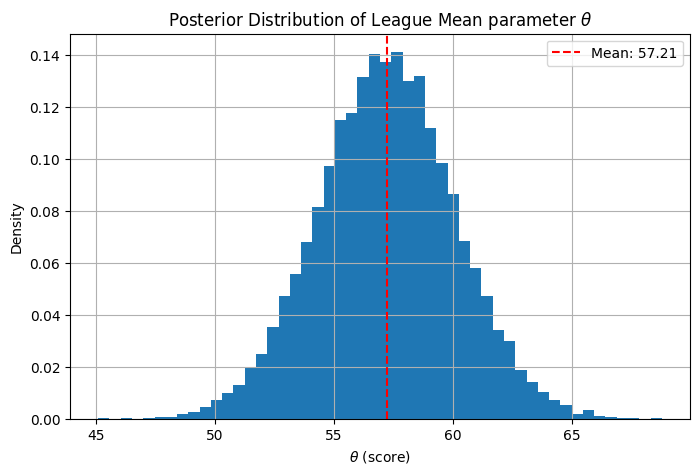

In [23]:
from matplotlib import pyplot as plt

def analyse_results(team_names, trace_mu, trace_theta, trace_sigma_sq, burn_in=1000):
    '''
    Computes posterior means and plots the histogram for theta.
    '''
    # Discard Burn-in
    clean_mu = trace_mu[burn_in:]
    clean_theta = trace_theta[burn_in:]
    clean_sigma_sq = trace_sigma_sq[burn_in:]

    # Calculate Posterior Means
    mean_theta = np.mean(clean_theta)
    mean_mu = np.mean(clean_mu, axis=0)
    mean_sigma_sq = np.mean(clean_sigma_sq, axis=0)

    # Print Table
    print(f"Posterior Mean for Theta (League Average): {mean_theta:.4f}\n")
    print(f"{'Team':<20} | {'Mean Score (mu_k)':<18} | {'Variance (sigma_k^2)':<20}")
    print("-" * 65)

    # Sort by score for readability
    sorted_indices = np.argsort(mean_mu)[::-1]

    for idx in sorted_indices:
        print(f"{team_names[idx]:<20} | {mean_mu[idx]:<18.4f} | {mean_sigma_sq[idx]:<20.4f}")

    # Plot Histogram for Theta
    plt.figure(figsize=(8, 5))
    plt.hist(clean_theta, bins=50, density=True)

    # Add vertical line for the mean
    plt.axvline(mean_theta, color='red', linestyle='dashed', label=f'Mean: {mean_theta:.2f}')

    plt.title(r'Posterior Distribution of League Mean parameter $\theta$')
    plt.xlabel(r'$\theta$ (score)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def process_data(raw_data):
    '''
    Separates team names from numerical data and determines dimensions.
    '''
    team_names = [row[0] for row in raw_data]
    # Extract scores (exclude name column)
    Y = np.array([row[1:] for row in raw_data], dtype=float)
    K, T = Y.shape
    return team_names, Y, K, T

team_names, Y, K, T = process_data(raw_data)

hp = {
    'sigma0': 10.0,
    'alpha0': 1e-5,
    'beta0':  1e-3,
    'mu0':    60.0,
    'tau0':   20.0
}

t_mu, t_theta, t_sigma = run_gibbs_sampler(Y, hp, n_iter=20000)
analyse_results(team_names, t_mu, t_theta, t_sigma, burn_in=2000)

The estimates and the histogram were obtained using the Ergodic Theorem for Markov Chains. The Gibbs sampler ran for $N$ iterations (e.g., 20,000) and generated a sequence of dependent samples $\theta^{(1)}, \theta^{(2)}, \dots, \theta^{(N)}$. We discarded the initial portion of the chain to allow the Markov chain to forget its arbitrary starting values and converge to the true posterior equilibrium distribution. The posterior mean for any parameter is estimated by taking the simple arithmetic average of the remaining samples.

The histogram for $\theta$ is unimodal as the conditional distribution for $\theta$ in our model is normal, and the marginal posterior tends toward normality given sufficient data, even in hierarchical models. The distribution is centered around the grand mean of the data but it is slightly pulled toward the prior mean $\mu_0$. Since the prior variance $\tau_0^2$ is relatively large (weakly informative), the center is determined mostly by the average of the team averages. The width of the histogram represents our posterior uncertainty about the true league average. This uncertainty accounts for the fact that we only observe a finite number of teams and a finite number of years.

---

To estimate the posterior probability $\Pr(\mu_k > \theta | y)$, we use the samples generated by the Gibbs sampler. In Bayesian inference, a probability can be estimated as an expectation of an indicator function,
\begin{equation}
    \Pr(\mu_k > \theta | y) = E[I(\mu_k > \theta) | y].
\end{equation}
Using our MCMC samples (after removing burn-in), we count the fraction of iterations where the sampled team mean $\mu_k^{(n)}$ is greater than the sampled league mean $\theta^{(n)}$,
\begin{equation}
    \hat{P} \approx \frac{1}{N} \sum_{n=1}^{N} I(\mu_k^{(n)} > \theta^{(n)}).
\end{equation}

In [30]:
def estimate_prob_above_average(team_name, team_names, trace_mu, trace_theta, burn_in=1000):
    '''
    Estimates P(mu_k > theta | y) by counting the proportion of samples
    where the team mean exceeds the league mean.
    '''
    # Find the index of the chosen team
    k = team_names.index(team_name)

    # Extract clean samples (post burn-in)
    mu_samples = trace_mu[burn_in:, k]
    theta_samples = trace_theta[burn_in:]

    # Calculate the proportion where mu_k > theta
    count_above = np.sum(mu_samples > theta_samples)
    total_samples = len(mu_samples)

    probability = count_above / total_samples

    return probability

team_a = "Arsenal"
prob_a = estimate_prob_above_average(team_a, team_names, t_mu, t_theta, burn_in=2000)
team_b = "Charlton Athletic"
prob_b = estimate_prob_above_average(team_b, team_names, t_mu, t_theta, burn_in=2000)
team_c = "Newcastle United"
prob_c = estimate_prob_above_average(team_c, team_names, t_mu, t_theta, burn_in=2000)

print("-" * 65)
print(f"Posterior Probability of being 'Above Average' (P(mu_k > theta))")
print("-" * 65)
print(f"{team_a:<20}: {prob_a:.4f}  ({prob_a*100:.1f}%)")
print(f"{team_c:<20}: {prob_c:.4f}  ({prob_c*100:.1f}%)")
print(f"{team_b:<20}: {prob_b:.4f}  ({prob_b*100:.1f}%)")

-----------------------------------------------------------------
Posterior Probability of being 'Above Average' (P(mu_k > theta))
-----------------------------------------------------------------
Arsenal             : 0.9973  (99.7%)
Newcastle United    : 0.7042  (70.4%)
Charlton Athletic   : 0.0068  (0.7%)


N (Samples)  | Var(Est. Mean)       | Var(Est. Prob)      
------------------------------------------------------------
100          | 0.30016721           | 0.00172737          
500          | 0.05446983           | 0.00028821          
1000         | 0.05302306           | 0.00024830          
5000         | 0.01007397           | 0.00004238          
10000        | 0.00182884           | 0.00001121          


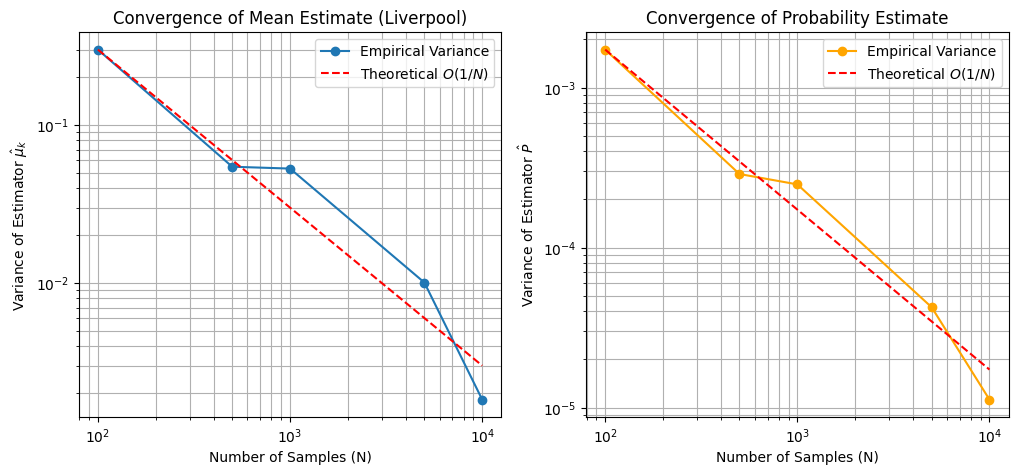

In [35]:
def analyze_convergence(Y, hp, team_name, team_names, N_values, num_runs=20):
    '''
    Performs independent runs of the Gibbs sampler to estimate the variance
    of the estimators for mu_k and P(mu_k > theta).
    '''
    # Find team index
    k = team_names.index(team_name)

    results_mu_var = []
    results_prob_var = []

    # Fixed burn-in to ensure all chains start from equilibrium
    burn_in = 1000

    print(f"{'N (Samples)':<12} | {'Var(Est. Mean)':<20} | {'Var(Est. Prob)':<20}")
    print("-" * 60)

    for N in N_values:
        estimates_mu = []
        estimates_prob = []

        for r in range(num_runs):
            # Total iterations = burn_in + N samples for estimation
            total_iter = burn_in + N
            trace_mu, trace_theta, _ = run_gibbs_sampler(Y, hp, n_iter=total_iter)

            # Extract clean samples
            clean_mu_k = trace_mu[burn_in:, k]
            clean_theta = trace_theta[burn_in:]

            # Estimate Posterior Mean for this run
            est_mu = np.mean(clean_mu_k)
            estimates_mu.append(est_mu)

            # Estimate Probability P(mu_k > theta) for this run
            est_prob = np.mean(clean_mu_k > clean_theta)
            estimates_prob.append(est_prob)

        # Calculate sample variance of these independent estimates
        # ddof=1 provides an unbiased estimator of the variance
        var_mu = np.var(estimates_mu, ddof=1)
        var_prob = np.var(estimates_prob, ddof=1)

        results_mu_var.append(var_mu)
        results_prob_var.append(var_prob)

        print(f"{N:<12} | {var_mu:<20.8f} | {var_prob:<20.8f}")

    return results_mu_var, results_prob_var

N_to_test = [100, 500, 1000, 5000, 10000]
chosen_team = "Liverpool"
variances_mu, variances_prob = analyze_convergence(Y, hp, chosen_team, team_names, N_to_test, num_runs=20)

plt.figure(figsize=(12, 5))

# Variance of Mean Estimate
plt.subplot(1, 2, 1)
plt.plot(N_to_test, variances_mu, 'o-', label='Empirical Variance')
scale_factor = variances_mu[0] * N_to_test[0]
theoretical_line = [scale_factor / n for n in N_to_test]
plt.plot(N_to_test, theoretical_line, 'r--', label=r'Theoretical $O(1/N)$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel(r'Variance of Estimator $\hat{\mu}_k$')
plt.title(f'Convergence of Mean Estimate ({chosen_team})')
plt.legend()
plt.grid(True, which="both")

#  Variance of Probability Estimate
plt.subplot(1, 2, 2)
plt.plot(N_to_test, variances_prob, 'o-', color='orange', label='Empirical Variance')
scale_factor_p = variances_prob[0] * N_to_test[0]
theoretical_line_p = [scale_factor_p / n for n in N_to_test]
plt.plot(N_to_test, theoretical_line_p, 'r--', label=r'Theoretical $O(1/N)$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel(r'Variance of Estimator $\hat{P}$')
plt.title(f'Convergence of Probability Estimate')
plt.legend()
plt.grid(True, ls="-", which="both")

plt.show()

The sample variance represents the square of the Monte Carlo standard error (MCSE). It measures the error bars of the computation. This variance should decrease as $N$ increases. The Markov chain CLT states that for an ergodic chain, the variance of an estimator based on $N$ samples decays according to
\begin{equation}
    Var(\hat{\theta}_N) \approx \frac{\sigma_{chain}^2}{N}
\end{equation}
where $\sigma_{chain}^2$ relates to the variance of the posterior multiplied by an autocorrelation factor since MCMC samples are not independent.

In [40]:
def check_burn_in_sensitivity(Y, hp, team_name, team_names, M_values, N_fixed=1000, num_runs=20):
    '''
    Tests how the sample variance of the estimator changes with different burn-in periods.
    '''
    k = team_names.index(team_name)

    results = []

    print(f"{'M':<15} | {'Sample Variance':<20}")
    print("-" * 40)

    for M in M_values:
        estimates = []

        for _ in range(num_runs):
            total_iters = M + N_fixed

            trace_mu, _, _ = run_gibbs_sampler(Y, hp, n_iter=total_iters)

            # Slice the array to keep only the last N samples (discard first M)
            # trace shape is (total_iters, K)
            kept_samples = trace_mu[M:, k]

            # Calculate the posterior mean estimate for this run
            est_mean = np.mean(kept_samples)
            estimates.append(est_mean)

        # Calculate the variance of these estimates across the independent runs
        sample_variance = np.var(estimates, ddof=1)
        results.append(sample_variance)

        print(f"{M:<15} | {sample_variance:<20.8f}")

N_fixed_param = 1000
M_values_to_test = [0, 20, 100, 500, 2000]
check_burn_in_sensitivity(Y, hp, "Tottenham Hotspur", team_names, M_values_to_test, N_fixed=N_fixed_param, num_runs=30)

M               | Sample Variance     
----------------------------------------
0               | 0.01054492          
20              | 0.01044075          
100             | 0.00776765          
500             | 0.00834900          
2000            | 0.00748436          


There is very little noticeable difference in the sample variances between $M=0$ and $M=2000$. This is due to the initialization strategy of the Markov chain which used the sample statistics of the data. The posterior mode for this normal-normal hierarchical model is mathematically very close to these sample statistics. By starting the chain at the sample means, we initialised the chain inside the high-probability region of the equilibrium distribution.

The purpose of the burn-in $M$ is to discard the early samples where the chain is travelling from an arbitrary starting point to the equilibrium distribution. Since our chain started at the destination, there was no travel time required.

Scenario             | Est. Theta (Last 1000 iter)   
-------------------------------------------------------
Low Start            | 57.3128
Data Start           | 57.1300
High Start           | 57.5836


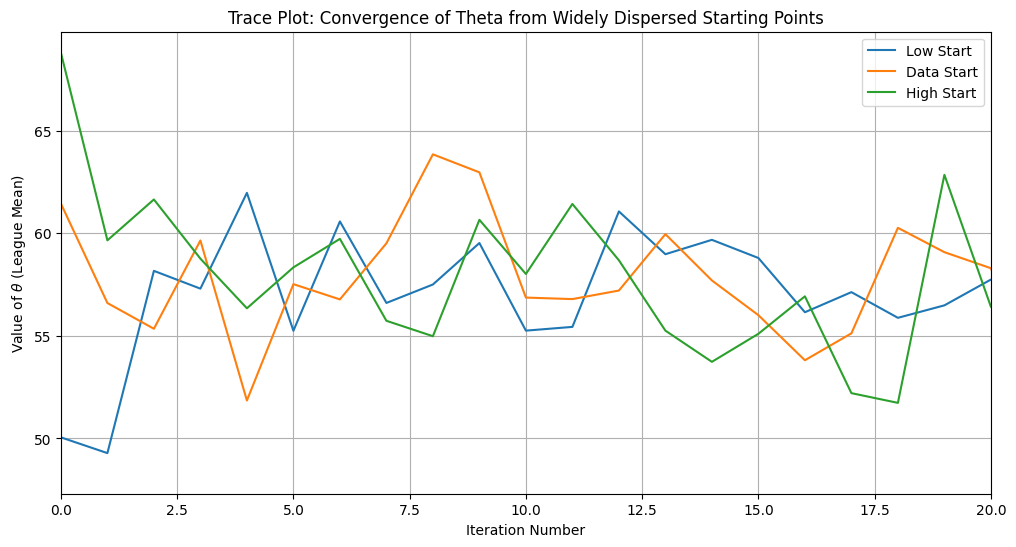

In [47]:
def run_chain_with_start(Y, hp, start_val, label, n_iter=2000):
    '''
    Runs the Gibbs sampler starting from a specific fixed value for all parameters.
    '''
    K, T = Y.shape

    # Force mu and theta to the specified start value
    curr_mu = np.full(K, start_val, dtype=float)
    curr_theta = float(start_val)

    # Initialise sigma_sq to 100 (generic variance) to avoid division by zero
    curr_sigma_sq = np.full(K, 100.0)

    # Storage
    trace_theta = np.zeros(n_iter)

    # Gibbs Loop
    for i in range(n_iter):
        curr_mu = update_mu(Y, curr_sigma_sq, curr_theta, hp)
        curr_theta = update_theta(curr_mu, hp)
        curr_sigma_sq = update_sigma_sq(Y, curr_mu, hp)
        trace_theta[i] = curr_theta
    return trace_theta

scenarios = [
    {"label": "Low Start", "val": 0},
    {"label": "Data Start", "val": 60},
    {"label": "High Start", "val": 114}
]

traces = {}

print(f"{'Scenario':<20} | {'Est. Theta (Last 1000 iter)':<30}")
print("-" * 55)

plt.figure(figsize=(12, 6))

for sc in scenarios:
    trace = run_chain_with_start(Y, hp, sc["val"], sc["label"], n_iter=500)
    traces[sc["label"]] = trace

    final_mean = np.mean(trace[250:])
    print(f"{sc['label']:<20} | {final_mean:.4f}")

    plt.plot(trace, label=sc["label"])

plt.title('Trace Plot: Convergence of Theta from Widely Dispersed Starting Points')
plt.xlabel('Iteration Number')
plt.ylabel(r'Value of $\theta$ (League Mean)')
plt.legend()
plt.grid(True)
plt.xlim(0, 20)
plt.show()

Despite starting at widely different values, all three chains converge to the same region extremely quickly, within $10$ iterations. After this initial rapid movement, the traces overlap and become indistinguishable from each other. This confirms that the results of the Gibbs sampler are independent of the starting point, provided the chain is run long enough. It verifies that the chain is ergodic which means that it can reach any part of the posterior distribution from any starting state.

In the context of dispersed starting points, the initial $M$ burn-in is critical. If we included the first few iterations in our estimate, then the results would be heavily biased by the starting position. The variance across the different chains would be large because their averages would differ significantly due to the initial values.